In [1]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


dataset_root = '1-condition-splited-data'


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),         
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root=dataset_root + '/train', transform=transform)
test_dataset = ImageFolder(root=dataset_root + '/test', transform=transform)
val_dataset = ImageFolder(root=dataset_root+"/validation",transform=transform)


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

C:\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import torch
import torch.nn as nn

class DeepCNNWithBatchNormAndDropout(nn.Module):
    def __init__(self,dropoutValue):
        super(DeepCNNWithBatchNormAndDropout, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3)
        self.batch_norm4 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * 12 * 12, 2048)
        self.batch_norm_fc1 = nn.BatchNorm1d(2048)
        self.dropout1 = nn.Dropout(dropoutValue)
        self.fc2 = nn.Linear(2048, 2048)
        self.batch_norm_fc2 = nn.BatchNorm1d(2048)
        self.dropout2 = nn.Dropout(dropoutValue)
        self.fc3 = nn.Linear(2048, len(train_dataset.classes))
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.batch_norm2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.batch_norm3(self.conv3(x)))
        x = self.relu(self.batch_norm4(self.conv4(x)))
        x = self.pool(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.dropout1(self.relu(self.batch_norm_fc1(self.fc1(x))))
        x = self.dropout2(self.relu(self.batch_norm_fc2(self.fc2(x))))
        x = self.fc3(x)
        return x


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
INPUT_SIZE = (224,224,3)

W,H,C = INPUT_SIZE
input_size = W*H*C
model = DeepCNNWithBatchNormAndDropout(0.5).to(device)

saved_weights_path = "cnn-condition-1-best-model.pth"

model.load_state_dict(torch.load(saved_weights_path))

<All keys matched successfully>

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()

model.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        
        
        
        all_labels += labels.cpu().numpy().tolist()
        all_predictions += predicted.cpu().numpy().tolist()

test_loss /= len(test_loader.dataset)
accuracy = correct / len(test_loader.dataset) * 100.0

print(f'Test Loss: {test_loss}, Test Accuracy: {accuracy}%')


Test Loss: 0.0006499904960278018, Test Accuracy: 98.53333333333333%


Test Loss: 0.0006
Test Accuracy : 98.5333
Precision: 0.9853
Recall : 0.9853
F1 Score : 0.9853
Confusion Matrix:
[[978   1  21]
 [  1 999   0]
 [ 21   0 979]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1000
           1       1.00      1.00      1.00      1000
           2       0.98      0.98      0.98      1000

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



<Axes: >

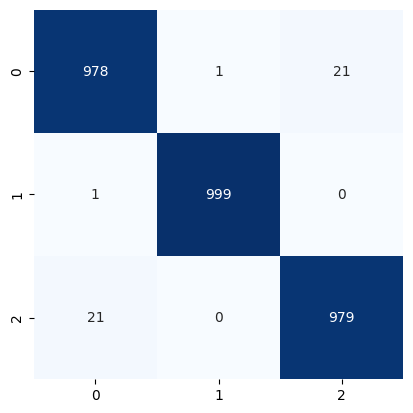

In [5]:
# Accuracy,  Precision, Recall ve F1 skoru, Karmaşıklık Matrisi, Classification Report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')
cm = confusion_matrix(all_labels, all_predictions)

print(f'Test Loss: {test_loss:.4f}')
print(f"Test Accuracy : {accuracy:.4f}")
print(f'Precision: {precision:.4f}')
print(f"Recall : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print('Confusion Matrix:')
print(cm)
print('\nClassification Report:')
print(classification_report(all_labels, all_predictions, target_names=[str(i) for i in range(len(test_dataset.classes))]))
sns.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)